# Exercises for Maps and Points
This week you are going to produce some Choropleths and Maps using *geopandas* and *folium*. Again use the plant data which was part of last weeks exercises. 

## Preparation
Start by importing the relevant libraries and loading the data into python.

In [23]:
#import libraries
%matplotlib inline

#load data and shapefile for choropleth
import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium as fo
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

pd.set_option('display.max_columns', None)

gdf_states = gpd.read_file("files/DEU_shape/DEU_adm1.shp") # source: https://gadm.org/
csv = 'files/conventional_power_plants_DE.csv'

# Read the file in
gpd_plants = gpd.read_file(csv)
df_plants = pd.read_csv(csv, index_col='id')
# Index it on the LSOA ID
gpd_plants = gpd_plants.set_index('id')
# Display summary
gpd_plants

name_bnetza          block_bnetza  name_uba  \
id                                                                      
BNA0012a  Werkskraftwerk Sappi Alfeld             Turbine 5             
BNA0021                HKW Altenstadt                                   
BNA0027        Zellstoff Stendal GmbH                     -  Arneburg   
BNA1337b         Blockheizkraftwerk 1  Blockheizkraftwerk 1             
BNA1337c         Blockheizkraftwerk 2  Blockheizkraftwerk 2             
...                               ...                   ...       ...   
BNA1316             Müllheizkraftwerk                                   
BNA1449a                  Turbosatz 1                                   
BNA1449b                  Turbosatz 2                                   
BNA1286   Restabfallbehandlungsanlage                     1             
BNA1867                      AVG Köln           Turbosatz 2             

                                                    company  \
id                                                            
BNA0012a                                  Sappi Alfeld GmbH   
BNA0021              Heizkraftwerk Altenstadt GmbH & Co. KG   
BNA0027                              Zellstoff Stendal GmbH   
BNA1337b                    DS Smith Paper Deutschland GmbH   
BNA1337c                    DS Smith Paper Deutschland GmbH   
...                                                     ...   
BNA1316     AWG Abfallwirtschaftsgesellschaft mbH Wuppertal   
BNA1449a        Zweckverband Abfallwirtschaft Raum Würzburg   
BNA1449b        Zweckverband Abfallwirtschaft Raum Würzburg   
BNA1286   Zweckverband für Abfallwirtschaft Südwestthüri...   
BNA1867                                        AVG Köln mbH   

                          street postcode           city                state  \
id                                                                              
BNA0012a          Mühlenmarsch 1    31061         Alfeld        Niedersachsen   
BNA0021           Triebstraße 90    86972     Altenstadt               Bayern   
BNA0027      Goldbecker Straße 1    39596       Arneburg       Sachsen-Anhalt   
BNA1337b          Weichertstr. 7    63741  Aschaffenburg               Bayern   
BNA1337c          Weichertstr. 7    63741  Aschaffenburg               Bayern   
...                          ...      ...            ...                  ...   
BNA1316               Korzert 15    42349      Wuppertal  Nordrhein-Westfalen   
BNA1449a        Gattingerstr. 31    97076       Würzburg               Bayern   
BNA1449b        Gattingerstr. 31    97076       Würzburg               Bayern   
BNA1286                             98544   Zella-Mehlis            Thüringen   
BNA1867   Geestemünder Straße 23    50735           Köln  Nordrhein-Westfalen   

         country_code capacity_net_bnetza capacity_gross_uba  \
id                                                             
BNA0012a           DE                  16                      
BNA0021            DE                 9.8                      
BNA0027            DE               138.9                147   
BNA1337b           DE                 1.1                      
BNA1337c           DE                 0.8                      
...               ...                 ...                ...   
BNA1316            DE                  30                      
BNA1449a           DE                 8.7                      
BNA1449b           DE                  12                      
BNA1286            DE                12.1                      
BNA1867            DE                  18                      

                        fuel     technology  chp chp_capacity_uba  \
id                                                                  
BNA0012a  Biomass and biogas  Steam turbine  yes                    
BNA0021   Biomass and biogas  Steam turbine   no                    
BNA0027   Biomass and biogas  Steam turbine  yes              600   
BNA1337b  Biomass and bi

In [24]:
gdf_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
ID_0         16 non-null int64
ISO          16 non-null object
NAME_0       16 non-null object
ID_1         16 non-null int64
NAME_1       16 non-null object
TYPE_1       16 non-null object
ENGTYPE_1    16 non-null object
NL_NAME_1    0 non-null object
VARNAME_1    9 non-null object
geometry     16 non-null geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 1.4+ KB


## Exercise 1
Using geopandas, create 3 different Choropleths showing the number of power plants per state using...
1. equally distributed bins and
2. quantiles for the colouring. 
3. Finally investigate the distribution of the number of plants using a KDE plot.

Hints:
* Obviously, you need to aggregate the data in an appropriate way using e.g. pandas. See discussion at <a href="https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-per-group-and-other-statistics-in-pandas-group-by">stackoverlow</a>.
* Also, you need to *<a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html#pandas.DataFrame.merge">merge</a>* the geo dataframe (shape file) with the pandas dataframe (csv).
* Use an appropriate <a href="https://matplotlib.org/users/colormaps.html">colormap</a> such as 'viridis'.

In [25]:
# prepare the data to get the no of plants per state
gpd_plants_size = gpd_plants.groupby(['state']).size().to_frame()
gpd_plants_size

0
state                      
Baden-Württemberg        86
Bayern                  155
Berlin                   14
Brandenburg              43
Bremen                   11
Hamburg                   8
Hessen                   38
Luxemburg                11
Mecklenburg-Vorpommern   12
Niedersachsen            60
Nordrhein-Westfalen     185
Rheinland-Pfalz          34
Saarland                 17
Sachsen                  26
Sachsen-Anhalt           41
Schleswig-Holstein       19
Schweiz                   1
Thüringen                28
Österreich               17

In [26]:
gdf_merged = gdf_states.merge(gpd_plants_size, left_on='NAME_1', right_on='state')
gdf_merged.rename(columns={0:'count'}, inplace=True)
gdf_merged

ID_0  ISO   NAME_0  ID_1                  NAME_1 TYPE_1 ENGTYPE_1  \
0     86  DEU  Germany     1       Baden-Württemberg   Land     State   
1     86  DEU  Germany     2                  Bayern   Land     State   
2     86  DEU  Germany     3                  Berlin   Land     State   
3     86  DEU  Germany     4             Brandenburg   Land     State   
4     86  DEU  Germany     5                  Bremen   Land     State   
5     86  DEU  Germany     6                 Hamburg   Land     State   
6     86  DEU  Germany     7                  Hessen   Land     State   
7     86  DEU  Germany     8  Mecklenburg-Vorpommern   Land     State   
8     86  DEU  Germany     9           Niedersachsen   Land     State   
9     86  DEU  Germany    10     Nordrhein-Westfalen   Land     State   
10    86  DEU  Germany    11         Rheinland-Pfalz   Land     State   
11    86  DEU  Germany    12                Saarland   Land     State   
12    86  DEU  Germany    13          Sachsen-Anhalt   Land     State   
13    86  DEU  Germany    14                 Sachsen   Land     State   
14    86  DEU  Germany    15      Schleswig-Holstein   Land     State   
15    86  DEU  Germany    16               Thüringen   Land     State   

   NL_NAME_1                   VARNAME_1  \
0       None                        None   
1       None                     Bavaria   
2       None                        None   
3       None                        None   
4       None                        None   
5       None                        None   
6       None                       Hesse   
7       None  Mecklenburg-West Pomerania   
8       None                Lower Saxony   
9       None      North Rhine-Westphalia   
10      None        Rhineland-Palatinate   
11      None                        None   
12      None               Saxony-Anhalt   
13      None                      Saxony   
14      None                        None   
15      None                   Thuringia   

                                             geometry  count  
0   MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7...     86  
1   POLYGON ((10.13386 50.55000, 10.13980 50.54252...    155  
2   POLYGON ((13.17789 52.39032, 13.16575 52.39050...     14  
3   POLYGON ((13.87951 53.50107, 13.87927 53.49908...     43  
4   MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2...     11  
5   POLYGON ((10.07162 53.71823, 10.07150 53.72192...      8  
6   POLYGON ((9.49877 51.63152, 9.50474 51.62795, ...     38  
7   MULTIPOLYGON (((14.26472 53.71069, 14.26472 53...     12  
8   MULTIPOLYGON (((6.86528 53.59597, 6.86528 53.5...     60  
9   POLYGON ((8.66628 52.52528, 8.67277 52.51795, ...    185  
10  POLYGON ((7.79963 50.94302, 7.81179 50.93973, ...     34  
11  POLYGON ((7.03796 49.64338, 7.05590 49.63674, ...     17  
12  POLYGON ((11.63251 53.01641, 11.63239 53.00897...     41  
13  POLYGON ((12.87800 51.67270, 12.87185 51.66910...     26  
14  MULTIPOLYGON (((8.68972 54.06681, 8.68972 54.0...     19  
15  POLYGON ((10.77189 51.64491, 10.78391 51.64098...     28

In [27]:
# plot the data using geopandas.plot using equal intervals
classi = ps.Equal_Interval(gdf_merged['count'], k=7)
classi

              Equal Interval             
 
 Lower            Upper             Count
          x[i] <=  33.286               8
 33.286 < x[i] <=  58.571               4
 58.571 < x[i] <=  83.857               1
 83.857 < x[i] <= 109.143               1
109.143 < x[i] <= 134.429               0
134.429 < x[i] <= 159.714               1
159.714 < x[i] <= 185.000               1

In [28]:
classi.bins

array([ 33.28571429,  58.57142857,  83.85714286, 109.14285714,
       134.42857143, 159.71428571, 185.        ])

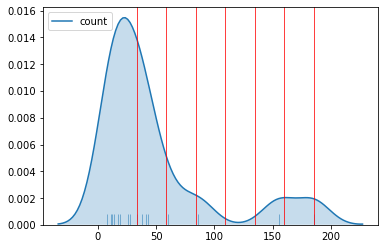

In [29]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(gdf_merged['count'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(gdf_merged['count'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

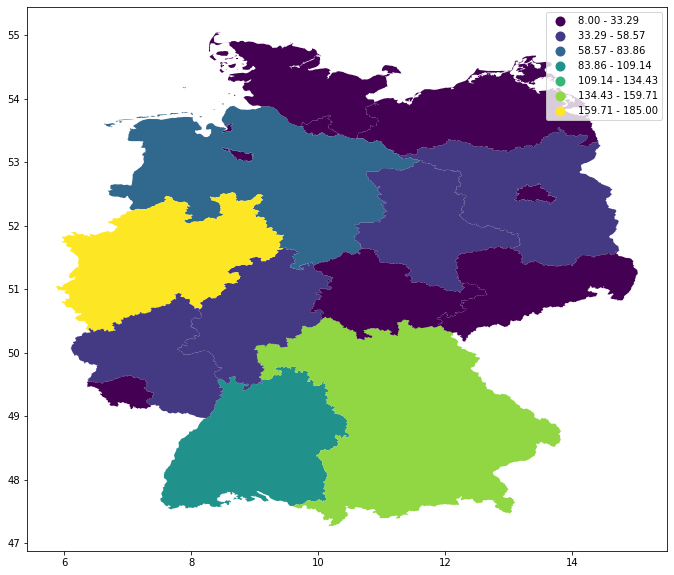

In [30]:
gdf_merged.plot(column='count', scheme='equal_interval', k=7, cmap=plt.cm.viridis, alpha=1,figsize=(15,10), legend=True)

In [31]:
# plot the data using geopandas.plot using quantiles
classi2 = ps.Quantiles(gdf_merged['count'], k=7)
classi2

                Quantiles                
 
 Lower            Upper             Count
          x[i] <=  12.286               3
 12.286 < x[i] <=  17.571               2
 17.571 < x[i] <=  26.857               2
 26.857 < x[i] <=  36.286               2
 36.286 < x[i] <=  42.429               2
 42.429 < x[i] <=  82.286               2
 82.286 < x[i] <= 185.000               3

In [32]:
classi2.bins

array([ 12.28571429,  17.57142857,  26.85714286,  36.28571429,
        42.42857143,  82.28571429, 185.        ])

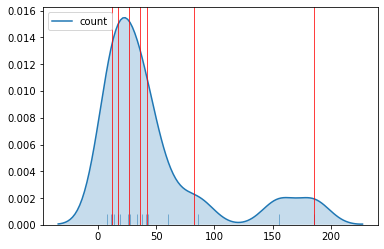

In [33]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(gdf_merged['count'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(gdf_merged['count'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi2.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

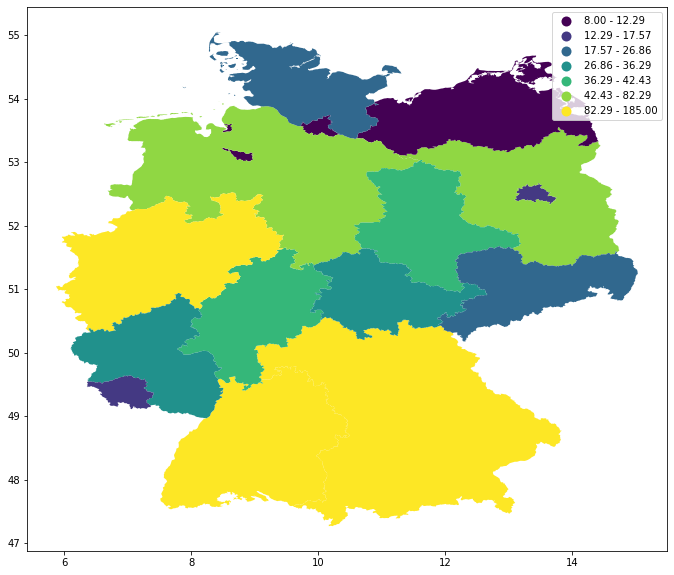

In [34]:
f, ax = plt.subplots(1,figsize=(15,10))
gdf_merged.plot(ax=ax,column='count', scheme='QUANTILES', alpha=1, k=7, cmap=plt.cm.viridis, legend=True)

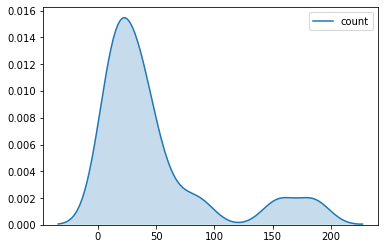

In [35]:
# plot a kdeplot using seaborn to show the distribution
sns.kdeplot(gdf_merged['count'], shade=True)

## Exercise 2
Create a map showing the locations of power plants in Baden-Württemberg using folium. Use the column 'technology' for the description of each marker.

Hints:
* Baden Württemberg has its centroid at 48.661604,9.350134.
* One can iterate over each row of a data frame *df* using iterrows() like this:

  for index, row in df.iterrows():
      row['index1']....

In [36]:
# filter plants for Baden Württemberg
gpd_bw = gpd_plants[df_plants['state']=='Baden-Württemberg']
gpd_bw

name_bnetza  block_bnetza  \
id                                                                 
BNA0232a              Werkskraftwerk Sappi Ehingen                 
BNA0232b              Werkskraftwerk Sappi Ehingen                 
BNA1501                     Bio HKW Herbrechtingen                 
BNA0520                           Stora Enso Maxau                 
BNA0636                              BMKW Mannheim                 
...                                            ...           ...   
BNA0640                               HKW Mannheim     Turbine 3   
BNA0641a                              HKW Mannheim    Turbine 60   
BNA0641b                              HKW Mannheim   Turbine D.0   
BNA0641c                              HKW Mannheim   Turbine E.0   
BNA0939a  Restmüll-Heizkraftwerk Stuttgart-Münster  MÜN DT19 neu   

                   name_uba                                     company  \
id                                                                        
BNA0232a                                             Sappi Ehingen GmbH   
BNA0232b                                             Sappi Ehingen GmbH   
BNA1501                      Biomasse-Heizkraftwerk-Herbrechtingen GmbH   
BNA0520                                           Stora Enso Maxau GmbH   
BNA0636                                                  MVV Energie AG   
...                     ...                                         ...   
BNA0640                                                  MVV Energie AG   
BNA0641a                                                 MVV Energie AG   
BNA0641b                                                 MVV Energie AG   
BNA0641c                                                 MVV Energie AG   
BNA0939a  Stuttgart-Münster           EnBW Energie Baden-Württemberg AG   

                          street postcode            city              state  \
id                                                                             
BNA0232a    Kessel 5 - Turbine 5    89584         Ehingen  Baden-Württemberg   
BNA0232b    Kessel 4 - Turbine 3    89584         Ehingen  Baden-Württemberg   
BNA1501   Oskar-von-Miller-Weg 1    89542  Herbrechtingen  Baden-Württemberg   
BNA0520                             76187       Karlsruhe  Baden-Württemberg   
BNA0636         Otto-Hahn-Str. 1    68169        Mannheim  Baden-Württemberg   
...                          ...      ...             ...                ...   
BNA0640       Otto-Hahn-Straße 1    68169        Mannheim  Baden-Württemberg   
BNA0641a      Otto-Hahn-Straße 1    68169        Mannheim  Baden-Württemberg   
BNA0641b      Otto-Hahn-Straße 1    68169        Mannheim  Baden-Württemberg   
BNA0641c      Otto-Hahn-Straße 1    68169        Mannheim  Baden-Württemberg   
BNA0939a          Voltastraße 45    70376       Stuttgart  Baden-Württemberg   

         country_code capacity_net_bnetza capacity_gross_uba  \
id                                                             
BNA0232a           DE                13.2                      
BNA0232b           DE                   8                      
BNA1501            DE                  14                      
BNA0520            DE                  78                      
BNA0636            DE                17.9                      
...               ...                 ...                ...   
BNA0640            DE                 8.7                      
BNA0641a           DE                22.1                      
BNA0641b           DE                 8.1                      
BNA0641c           DE                 5.8                      
BNA0939a           DE                19.5           20.69565   

                        fuel     technology  chp  chp_capacity_uba  \
id                                                                   
BNA0232a  Biomass and biogas  Steam turbine  yes                     
BNA0232b  Biomass and biogas  Steam turbine  yes                     
BNA1501   Biomass and bi

In [37]:
# create a map showing Baden-Württemberg

# create a map
#state_geo = 'bw.geojson' # source http://opendatalab.de/projects/geojson-utilities/

m= fo.Map(location=[48.661604,9.350134], zoom_start=7)
m

In [38]:
# add markers for plants
gpd_bw.loc[:,'lat'] = gpd_bw.loc[:,'lat'].astype('float')
gpd_bw.loc[:,'lon'] = gpd_bw.loc[:,'lon'].astype('float')

for index, row in gpd_bw.iterrows():
    fo.Marker([gpd_bw.loc[index]['lat'], gpd_bw.loc[index]['lon']], popup=gpd_bw.loc[index]['name_bnetza']).add_to(m)
m.save('plants_in_bw.html')
m

/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Exercise 3
Finally, show a heatmap of the development of power plants (of any type) in Baden-Württemberg over time using folium. Use the *capacity_net_bnetza* as a weight. 

Hints:
* The centroid of Baden-Württemberg can be found in the Exercise above.
* You need a HeatMapWithTime. A documentation of the folium plug-ins can be found <a href="https://python-visualization.github.io/folium/plugins.html">here</a>.
* The parameters for *data* has to be a list of lists of coordinates[lat,lon] and *index* has to list of lists containing the *years*.

In [39]:
df_bw = df_plants[df_plants['state']=='Baden-Württemberg']
map_heat = fo.Map(location=[48.661604,9.350134],
                    zoom_start = 7) 

heat_data = [[row['lat'],row['lon']] for index, row in df_bw.iterrows()]
HeatMap(heat_data).add_to(map_heat)
map_heat

# Ignore the next cells/lines. Various HeatMapWithTime attempts.

In [40]:
#HeatMap(data=df_bw[['lat', 'lon', 'commissioned']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=6).add_to(m)
#m
#get the commissioned years from data frame and convert them to a list
# create a list of lists containing unique years as requiered for HeatMap
#time_index = [[row["commissioned"]] for idx, row in df_bw.iterrows()]
# create a list of lists containing the coordinates of plants in question
#print(time_index)
#df_bw['commissioned'] = pd.to_datetime(df_bw['commissioned'], format='%Y-%m-%d %H:%M:%S')
df_year_list = []
for year in df_bw['commissioned'].sort_values().unique():
    df_year_list.append(df_bw.loc[df_bw['commissioned'] == year, ['lat', 'lon', 'commissioned']].groupby(['lat', 'lon']).sum().reset_index().values.tolist())
#    df_year_list.append(df_bw.loc[df_bw['commissioned'] == year, ['lat', 'lon']].values)    
#    print(df_bw.loc[df_bw['commissioned'] == year, ['lat', 'lon']].values.tolist())
print(df_year_list)    

[[[47.5523554, 7.6580881, 1912.0]], [[48.673188399999994, 8.355705841, 1918.0]], [[48.00795, 10.118537, 1923.0]], [[48.6693835, 8.353047617, 1926.0]], [[48.527536, 9.3488325, 1927.0]], [[47.585377, 7.832657000000001, 1931.0], [47.75459, 8.18787, 1931.0]], [[47.586290000000005, 8.13207, 1933.0]], [[47.57136, 8.33826, 1941.0]], [[47.687909999999995, 8.25159, 1943.0]], [[47.61777, 8.1926, 1951.0]], [[48.26693, 9.72626, 1961.0]], [[48.50499, 9.28692, 1964.0], [49.017472, 9.157389, 1964.0]], [[49.177334, 9.206318, 1965.0]], [[47.558531200000004, 7.955657899999999, 1966.0], [47.565416, 7.954035, 1966.0], [49.177334, 9.206318, 1966.0]], [[49.017472, 9.157389, 1967.0]], [[48.750809999999994, 9.1103, 1968.0]], [[48.750809999999994, 9.1103, 1969.0]], [[48.717611, 9.374917, 1971.0], [48.927496999999995, 9.230005, 1971.0]], [[48.717611, 9.374917, 1973.0]], [[48.815833000000005, 9.221111, 5922.0]], [[47.64529898, 7.91819945, 1975.0], [48.717611, 9.374917, 1975.0], [48.927496999999995, 9.230005, 395

In [41]:
# create a map showing Baden-Württemberg
m_bw = fo.Map(location=[48.661604,9.350134],tiles='stamentoner', zoom_start=7)
#create HeatMapWithTime
#add heatmap as overlay for map
hm = HeatMapWithTime(df_year_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True, auto_play=True)
#HeatMapWithTime(df_year_list, index=df_bw['commissioned'].sort_values().unique()).add_to(m_bw)
#show the plants
hm.add_to(m_bw)
m_bw


In [42]:
df_bw = df_plants[df_plants['state']=='Baden-Württemberg']
#HeatMap(data=df_bw[['lat', 'lon', 'commissioned']].groupby(['lat', 'lon']).sum().reset_index().values.tolist(), radius=8, max_zoom=6).add_to(m)
#m
#get the commissioned years from data frame and convert them to a list
# create a list of lists containing unique years as requiered for HeatMap
time_index = [row["commissioned"] for idx, row in df_bw.iterrows()]
time_index.sort()
# create a list of lists containing the coordinates of plants in question
#print(time_index)
#df_bw['commissioned'] = pd.to_datetime(df_bw['commissioned'], format='%Y-%m-%d %H:%M:%S')
heat_coordinates = [[row['lat'],row['lon']] for time_index, row in df_bw.iterrows()]
print(time_index)

[1912.0, 1918.0, 1923.0, 1926.0, 1927.0, 1931.0, 1931.0, 1933.0, 1941.0, 1961.0, 1964.0, 1964.0, 1965.0, 1966.0, 1966.0, 1966.0, 1967.0, 1978.0, 1982.0, 1982.0, 1984.0, 1985.0, 1985.0, 1985.0, 1990.0, 1990.0, 1993.0, 1997.0, 2000.0, 2003.0, 2003.0, 2004.0, 2004.0, 2005.0, 2009.0, 2009.0, 2010.0, 2010.0, 2012.0, 2013.0, 2014.0, 2015.0, nan, 1943.0, 1951.0, 1968.0, 1969.0, 1971.0, 1971.0, 1973.0, 1974.0, 1974.0, 1974.0, 1975.0, 1975.0, 1975.0, 1975.0, 1976.0, 1980.0, 1980.0, 1981.0, 1984.0, 1985.0, 1988.0, 1989.0, 1995.0, 1995.0, 1997.0, 1998.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2004.0, 2005.0, 2005.0, 2005.0, 2009.0, 2009.0, 2009.0, 2011.0, 2012.0, 2012.0, 2013.0, 2014.0]


In [43]:
map_2 = fo.Map(location=[48.661604,9.350134],
                    zoom_start = 7)
heatmap = HeatMapWithTime(heat_coordinates, index=time_index, auto_play=True, display_index=True).add_to(map_2)
map_2

In [44]:
map_3 = fo.Map(location=[48.661604,9.350134],
                    zoom_start = 7)
heatmap = HeatMap(heat_coordinates).add_to(map_3)
map_3